In [13]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from optimization_tuned import (epsilon_nondominated,HypervolumeMetric, Hypervolume, ArchiveLogger, 
                                AbstractConvergenceMetric, EpsilonProgress)

from optimization_tuned import epsilon_nondominated, to_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
    ScalarOutcome
)
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant
#from ema_workbench.em_framework.optimization import EpsilonProgress

from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator,
                           Scenario, Policy, perform_experiments, ema_logging)
from ema_workbench.em_framework.optimization import HyperVolume


ema_logging.log_to_stderr(ema_logging.INFO)

import pickle
warnings.filterwarnings("ignore")

## Robustness Metrics

## General setup

### Setup using DB results

In [14]:
#Defining the model
dike_model, planning_steps = get_model_for_problem_formulation(6)

In [15]:
#Load results coming from Delft Blue for scenario 0
scenario_0_results = []
for i in range(3):
    with open(f"DB_results\Seed-{i}Scen-0.pkl", 'rb') as file:
        seed_result = pickle.load(file)
        scenario_0_results.append(seed_result[0])
        
#Load results coming from Delft Blue for scenario 1      
scenario_1_results = []
for i in range(2):
    with open(f"DB_results\Seed-{i}Scen-1.pkl", 'rb') as file:
        seed_result = pickle.load(file)
        scenario_1_results.append(seed_result[0])


In [16]:
#Defining the problem
problem = to_problem(dike_model, searchover="levers")

In [17]:
#Make sure only the relevant policies coming from Open Exploration are taken into account in both the problem and the dike_model

levers_to_delete = ["A.1_DikeIncrease 0","A.1_DikeIncrease 1","A.1_DikeIncrease 2","A.2_DikeIncrease 0",
                    "A.2_DikeIncrease 1","A.2_DikeIncrease 2","A.3_DikeIncrease 1","A.3_DikeIncrease 2","A.4_DikeIncrease 0",
                    "A.4_DikeIncrease 1","A.4_DikeIncrease 2","A.5_DikeIncrease 2","0_RfR 0","0_RfR 1","0_RfR 2","1_RfR 0",
                    "1_RfR 1","1_RfR 2","4_RfR 0","4_RfR 1","4_RfR 2"]

for lever in levers_to_delete:
    problem.parameters.__delitem__(lever)

#Update the number of levers of the problem instance, because somehow this does not get updated automatically
problem.nvars = 10

### Merge Seeds

In [18]:
#Merge the results from the different seeds for each scenario
#epsilons = [0.1, 0.1, 10000, 0.1, 10000, 0.1]
epsilons = [0.05] * len(dike_model.outcomes)

merged_results_0 = epsilon_nondominated(scenario_0_results, epsilons, problem)

merged_results_1 = epsilon_nondominated(scenario_1_results, epsilons, problem)

### Remove duplicate candidate strategies from the two scenarios

In [19]:
merged_results = pd.concat([merged_results_0, merged_results_1], axis=0)

In [20]:
unique_results = merged_results.drop_duplicates(subset=merged_results.columns[:10])

In [22]:
unique_results.groupby('EWS_DaysToThreat')['Expected Evacuation Costs'].mean()

EWS_DaysToThreat
0        0.000000
1     4456.780436
2    37767.790275
Name: Expected Evacuation Costs, dtype: float64

## Policy setup



In [106]:
merged_results['Expected Number of Deaths'].histplot()

AttributeError: 'Series' object has no attribute 'histplot'

In [11]:
#We add manual constraints, as we want 0 deaths in dike ring 5 and no evacuation, so no evacuation costs
filter = (#(merged_results['A.5_Expected Number of Deaths'] < 0.001) & 
          #(merged_results['EWS_DaysToThreat'] <= 1 ) & 
          (merged_results['Expected Evacuation Costs'] < 0.001))

#We add the constraint of EWS to be max 1 day, in order to minimize evacuation
#Minimizing evacuation costs gave too little candidate strategies
policies = merged_results[filter]

#Just keep in the policies, and get rid of the outcomes
policies = policies.drop([o.name for o in dike_model.outcomes], axis=1)

In [12]:
policies

,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,3_RfR 1,3_RfR 2,EWS_DaysToThreat,A.3_DikeIncrease 0,A.5_DikeIncrease 0,A.5_DikeIncrease 1
2,0,0,0,0,0,0,0,0,3,0
4,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,1,2,0
12,1,0,1,1,0,0,0,0,1,0
24,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,1,0,0
27,0,0,0,0,0,0,0,0,1,0
29,0,0,0,0,0,0,0,1,0,0
37,0,0,0,0,0,0,0,0,1,0
17,0,0,0,0,0,0,0,2,0,0


In [17]:
from ema_workbench import Policy

policy = {str(p): 0 for p in dike_model.levers}

policies_to_evaluate = []
for index, row in policies.iterrows():
    for p in policies.columns:
        policy[p] = row[p]
    policies_to_evaluate.append(Policy(f'Policy{index}', **policy))

In [20]:
##############Old code to create policy objects, only with selected levers from OE

#Create Policy objects
# policies_to_evaluate2 = []
# 
# for i, policy in policies.iterrows():
#     policies_to_evaluate2.append(Policy(str(i), **policy.to_dict()))

In [23]:
# Run 1000 scenarios for each of the policy options

n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
100%|██████████████████████████████████████| 3000/3000 [09:17<00:00,  5.38it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


## Signal to Noise ratio

In [110]:
#For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred.
#We want all our signal to noise ratios to be minimized

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [111]:
experiments, outcomes = results

In [112]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.5_Expected Number of Deaths,A.5_Expected Annual Damage,Expected Evacuation Costs,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
Policy12,0.002589,3.360529e+15,0.0,1.593297e+18,0.000000,0.905790
Policy2,0.000803,9.965062e+14,0.0,2.086405e+18,0.113068,1.944408
Policy9,0.002807,3.497169e+15,0.0,1.887081e+18,0.000000,1.480831


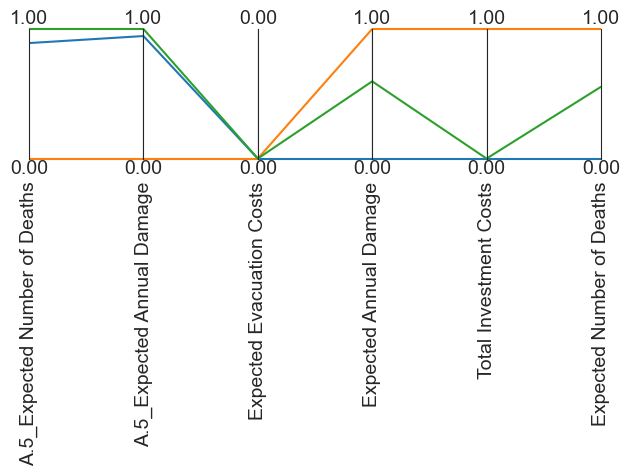

In [108]:
from ema_workbench.analysis import parcoords

data = scores

# Normalizing the data
zero_columns = data.columns[(data == 0).all()]
data_normalized = data.copy()
for col in data.columns:
    if col not in zero_columns:
        data_normalized[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())



limits = parcoords.get_limits(data_normalized)
limits.loc[0, ['A.5_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'Expected Evacuation Costs',
               'Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_normalized)
plt.show()

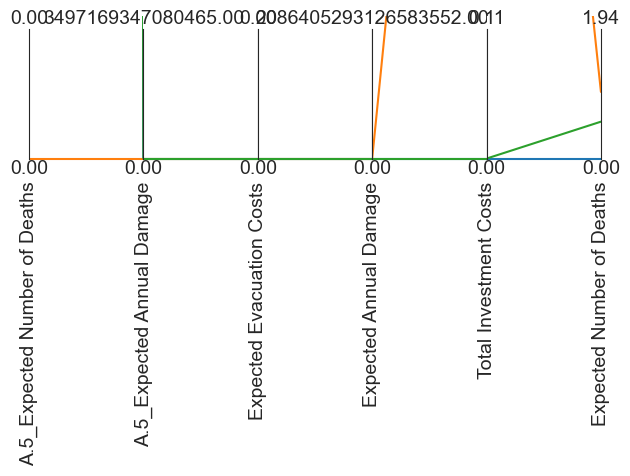

In [113]:
from ema_workbench.analysis import parcoords

data = scores


limits = parcoords.get_limits(data)
limits.loc[0, ['A.5_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'Expected Evacuation Costs',
               'Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_normalized)
plt.show()

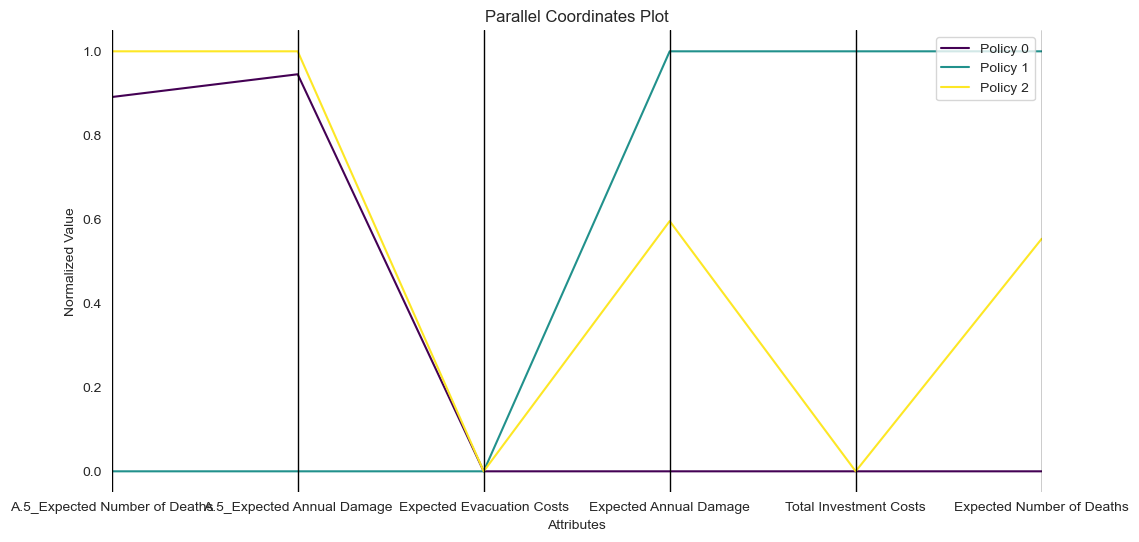

In [71]:
###############################Seaborn uitprobeersel, ik hoopte dat het zou lukken om de afgeronde getallen erop te zetten ipv van normalised, maar dat werkte niet

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

data = scores.copy()

# Normalize the data 
zero_columns = data.columns[(data == 0).all()]
data_normalized = data.copy()
for col in data.columns:
    if col not in zero_columns:
        data_normalized[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

data_normalized['class'] = ['Policy ' + str(i) for i in range(len(data_rounded))]

plt.figure(figsize=(12, 6))
parallel_coordinates(data_normalized, 'class', colormap=plt.get_cmap("viridis"))

plt.title("Parallel Coordinates Plot")
plt.xlabel("Attributes")
plt.ylabel("Normalized Value")

ax = plt.gca()

plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

## Regret

In [72]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [73]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

In [74]:
merged_results_0[filter]

,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,3_RfR 1,3_RfR 2,EWS_DaysToThreat,A.3_DikeIncrease 0,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_Expected Number of Deaths,A.5_Expected Annual Damage,Expected Evacuation Costs,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
2,0,0,0,0,0,0,0,0,3,0,0.0,0.0,0.0,2.902376e+08,3.337712e+07,0.297767
9,0,0,0,0,0,0,0,1,2,0,0.0,0.0,0.0,2.127689e+08,5.251934e+07,0.192004
12,1,0,1,1,0,0,0,0,1,0,0.0,0.0,0.0,1.880672e+08,2.101782e+08,0.165649


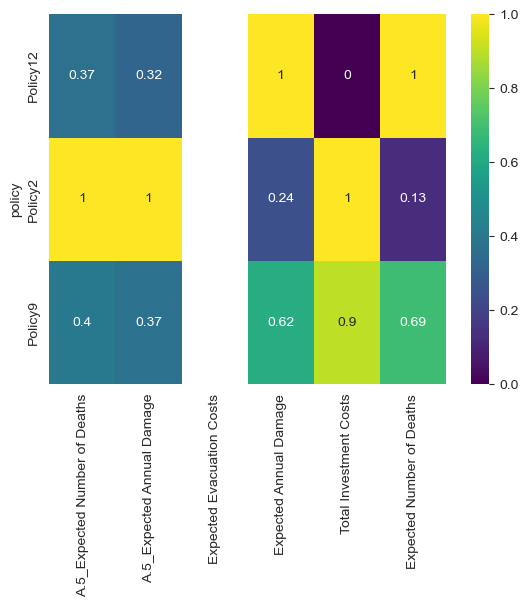

In [75]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret / max_regret.max(), cmap='viridis', annot=True)
plt.show()


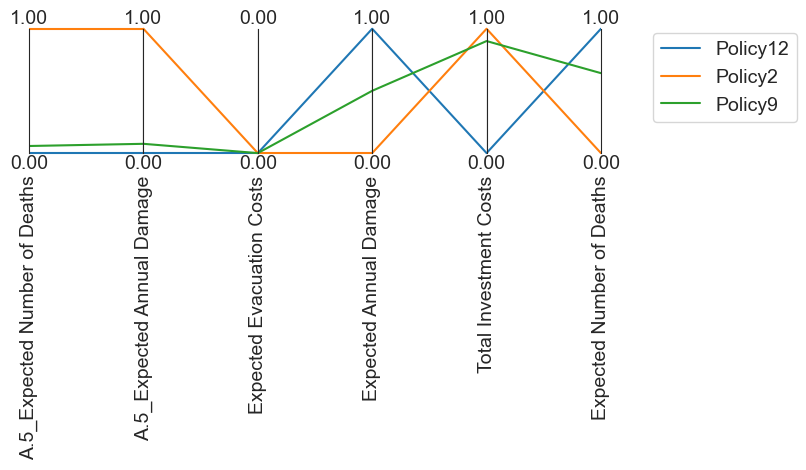

In [77]:
data = max_regret

colors = sns.color_palette(n_colors=len(data))

# Normalizing the data
zero_columns = data.columns[(data == 0).all()]
data_normalized = data.copy()
for col in data.columns:
    if col not in zero_columns:
        data_normalized[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())



# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data_normalized)
limits.loc[0, ['A.5_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'Expected Evacuation Costs',
               'Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data_normalized.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

In [37]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

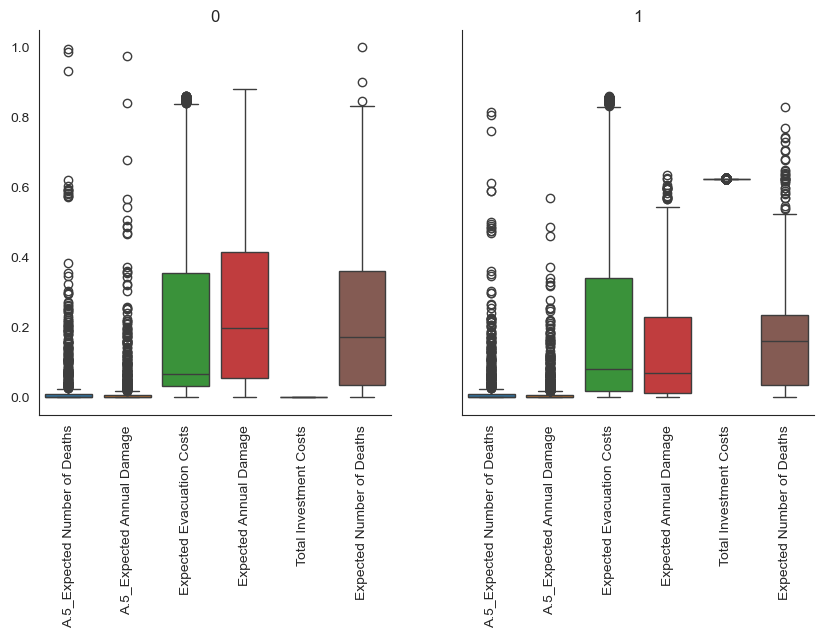

In [39]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 


# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
    
    # Rotate x-axis labels vertically
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
plt.show()